# A simple and useful quantum algorithm

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, array_to_latex
backend = BasicAer.get_backend('qasm_simulator')

Perhaps it's a bold claim, but I want to provide an introduction to quantum computing that is simple for someone without a University-level Mathematics or Physics background and yet creates the right intuitive understanding of how quantum computers work. I've done lots of intro courses on this topic myself, so I feel like I should be an expert on this by now. Please let me know if I've succeeded, or let me know where I could make it even simpler.

Quantum computers are very different from traditional digital computers (often called Classical computers by quantum computing folk). They use _qubits_, rather than _bits_ for their computation! In my introductory blog post, [What is a qubit?](https://aes.id.au/?p=1276), I used the analogy of a coin-flipping robot arm that is flipping a coin that lands on a table. A qubit is like the coin when it is in the air, and a bit is like the coin when it has ended up on the table. When it's in the air, the coin is in a kind of probabilistic state where it may end up heads or tails, but once it's on the table, it's in a certain state where it is definitely one of either heads or tails. Quantum computers work in the realm of probabilities, and can manipulate the coin while it's still spinning in the air. The spinning coin in the air is the qubit. But at some point it will land on the table and be measured as either heads or tails. At that point it becomes a bit.

To write about quantum states, a notation is used where the name of the state is put between a vertical bar and an angle bracket. Just like a single bit can be in the `0` state or the `1` state, for a single qubit, we might say it can be in the $|0\rangle$ state or the $|1\rangle$ state. Our hypothetical robot-arm is well-calibrated, so it consistently flips a coin that lands with the same side facing up, and it's like having a qubit in one of these states. It's in a probabilistic state, but the probability of it having a particular result is 100%. Similarly, if a qubit is in the $|0\rangle$ state, when it is measured, you will get a `0` result 100% of the time.

However, a quantum computer can manipulate the probabilities of the qubit, so even if it started in the $|0\rangle$ state, it enters a new state where if it is measured, it will get `0` 50% of the time (and `1` the other 50% of the time, of course). This is done using a Hadamard operation, usually just written as H. We will use this operation to create truly random numbers.

### Creating random numbers on a quantum computer 

Mostly when you have a computer give you a random number, such as using the [RAND function in Microsoft Excel](https://support.microsoft.com/en-us/office/rand-function-4cbfa695-8869-4788-8d90-021ea9f5be73) or when you're playing a computer game and the enemy does something unexpected, the computer is actually producing a pseudo-random number. If you could create a perfect snapshot of everything in your computer, then get it to do something "random", and return to that snapshot again, it will do exactly the same random thing each time. So, it's not actually random, but it looks random unless you peer too closely.

For most applications, that's fine. But if you are doing cryptography, having truly random numbers is important. You want to generate a secret key that no-one else can guess. Ideally, even if someone could take a snapshot of your computer, they still couldn't predict what secret key is generated. There are special hardware random number generators that can create truly random numbers ([Cloudflare uses lava lamps!](https://blog.cloudflare.com/randomness-101-lavarand-in-production/)), and quantum computers creates truly random numbers too.

Let's say we are going to generate a 2-bit random number. We'll use 2 qubits, and the starting state of the qubits will be $|00\rangle$, which means they are both 100% likely to measure as `0`s. We'll use a quantum computer to manipulate the qubits so that all four possibilities $|00\rangle$, $|01\rangle$, $|10\rangle$, or $|11\rangle$ are equally likely. Then when the qubits are measured, it will be completely random.

Another way to write this is as a vector, with each row consisting of the probability of that outcome. Quantum computers perform their calculations using complex numbers rather than real numbers. Techincally, when we have a vector of complex numbers, the probabilities are calculated by multiplying the numbers by their complex conjugate.  Doing the maths this way turns out to accurately describe how things work at the quantum level, but we can simplify it a bit. If a number is just a real number (without an imaginary component), the probability can be calculated by just squaring it.

This vector is the _quantum state vector_ and we will start with it being $\begin{bmatrix}
    1.0 \\
    0.0 \\
    0.0 \\
    0.0 \\
\end{bmatrix}$, i.e. 100% probability of getting the $|00\rangle$ outcome. Each row of the state vector corresponds to a different outcome, with the outcomes for two qubits being $|00\rangle$, $|01\rangle$, $|10\rangle$, and $|11\rangle$ as we go down the vector.

We will manipulate it into being $\begin{bmatrix}
    \frac{1}{\sqrt{4}} \\
    \frac{1}{\sqrt{4}} \\
    \frac{1}{\sqrt{4}} \\
    \frac{1}{\sqrt{4}} \\
\end{bmatrix}$, noting that this is the same as $\begin{bmatrix}
    \frac{1}{2} \\
    \frac{1}{2} \\
    \frac{1}{2} \\
    \frac{1}{2} \\
\end{bmatrix}$, but represents a $\frac{1}{4}$ or 25% probability of being measured as any of the four outcomes. Squaring $\frac{1}{\sqrt{4}}$ gets us the probability of $\frac{1}{4}$.

The H operation works on all pairs of rows of the quantum state vector that differ only by the value of a specific qubit, e.g. where one row has the $|0\rangle$ for that qubit and the other row has $|1\rangle$, and turns the first row value into a new value that is the sum of the original values divided by $\sqrt{2}$, and the second row value into the difference between the original values divided by $\sqrt{2}$. While it is a division by $\sqrt{2}$ rather than a division by $2$, you can think of H like a "half" operation, where it calculates half the sum and half the difference and is scaled by a normalisation constant so that when the values are squared, the probabilities add up to $1.0$. Written out mathematically, if the first row value is $a$ and the second row value is $b$, the first row value becomes $\frac{a+b}{\sqrt{2}}$ and the second row value becomes $\frac{a-b}{\sqrt{2}}$.

To get the desired final state vector from the initial state vector, we can apply H to the rows associated with a difference in the right-most qubit, then apply H to the rows associated with a difference in the left-most qubit. Here's how it would go:

| Qubits| Initial state vector | Calculating first H | Result of first H | Calculating second H | Result of second H |
| -: | -: | -: | -: | -: | -: |
| $\rvert00\rangle$ | $1.0$ | $= \frac{1.0 + 0.0}{\sqrt{2}}$ | $\frac{1}{\sqrt{2}}$ | $= \frac{\frac{1}{\sqrt{2}} + 0.0}{\sqrt{2}}$ | $\frac{1}{2}$ |
| $\rvert01\rangle$ | $0.0$ | $= \frac{1.0 - 0.0}{\sqrt{2}}$ | $\frac{1}{\sqrt{2}}$ | $= \frac{\frac{1}{\sqrt{2}} - 0.0}{\sqrt{2}}$ | $\frac{1}{2}$ |
| $\rvert10\rangle$ | $0.0$ | $= \frac{0.0 + 0.0}{\sqrt{2}}$ | $0.0$ | $= \frac{\frac{1}{\sqrt{2}} + 0.0}{\sqrt{2}}$ | $\frac{1}{2}$ |
| $\rvert11\rangle$ | $0.0$ | $= \frac{0.0 - 0.0}{\sqrt{2}}$ | $0.0$ | $= \frac{\frac{1}{\sqrt{2}} - 0.0}{\sqrt{2}}$ | $\frac{1}{2}$ |

Now that we've covered the process, let's look at how this would be written programmatically using the [Qiskit library](https://docs.quantum-computing.ibm.com/start/install) from IBM.

### Implementing this on Qiskit
We imported the relevant libraries at the top of this notebook. Ensure you've done that before progressing.

Now we're going to set up a (simulated) quantum computer with 2 qubits.

In [2]:
q = QuantumRegister(2)   # We want to use 2 qubits
algo = QuantumCircuit(q) # Readies us to construct an algorithm to run on the quantum computer

By convention, all qubits begin in the $|0\rangle$ state as the lowest-energy state, so without doing anything, the qubits of our quantum computer should be set to $|00\rangle$. We can check the state vector and see.

In [3]:
v1 = Statevector(algo)
array_to_latex(np.vstack(v1.data)) # Can do v1.draw("text") as an alternative when not in Jupyter Notebook

<IPython.core.display.Latex object>

Yes - the $|00\rangle$ row is $1.0$ and the other possibilities are $0.0$. 

Qiskit numbers the right-most qubit as qubit 0, and the one to the left of it as qubit 1, with the next as qubit 2, and so on. You may have come across this as being called [little-endian](https://www.geeksforgeeks.org/little-and-big-endian-mystery/). Let's start by using the H operator on pairs of rows associated with the $|0\rangle$ and $|1\rangle$ outcomes on qubit 0 (the right-most qubit).

In [4]:
algo.h(0)  # Apply H operation on pairs of rows related to qubit 0
v2 = Statevector(algo)
array_to_latex(np.vstack(v2.data))

<IPython.core.display.Latex object>

Depending on the visualisation, this may show $\frac{\sqrt{2}}{2}$ or 0.70710678, for the non-zero rows, which is the same as $\frac{1}{\sqrt{2}}$. In any case, it's what we were expecting. Now to do the H operation on the pairs of rows associated with the other qubit (qubit 1).

In [5]:
algo.h(1)  # Apply H operation on pairs of rows related to qubit 1
v3 = Statevector(algo)
array_to_latex(np.vstack(v3.data))

<IPython.core.display.Latex object>

The application of the H operations has set up the state vector so that the quantum computer should give us different randomly generated 2 bit values with uniform distribution. Let's add a measurement to the end of our algorithm, and have the quantum computer do this 1,000 times and see what we get.

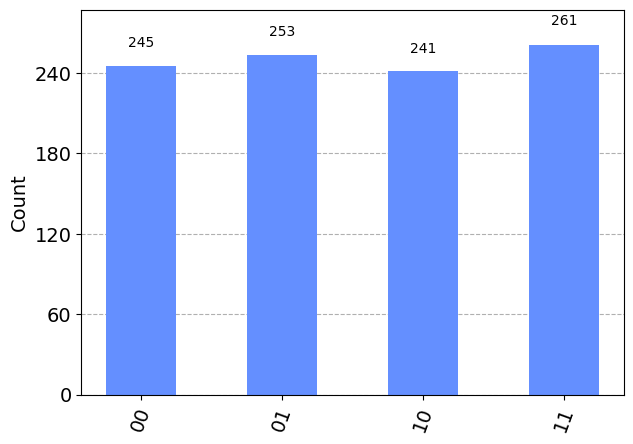

In [6]:
algo.measure_all()  # Measure the qubits and get some bits

result = execute(algo, backend, shots=1000).result()  # Run this all 1,000 times
plot_histogram(result.get_counts(algo))               # Show a histogram of the results

This shows that of the 1,000 times this was performed (1,000 "shots"), the different 2-bit results occurred approximately the same number of times. This is what you'd expect of a uniform distribution, noting that it is unlikely for every possibility to occur exactly the same number of times.

You can extend this process to as many random bits as you want, by having a qubit for each and applying the H operator in turn for each qubit. Quantum computers are still not very big, so you'll run out of available qubits quickly. In practice, you may be better just to re-run this process and get another two random bits each time.

We used a quantum computer simulator here, so it's still a pseudo-random result. To use an actual quantum computer, you would need to set up an account on [IBM Quantum](https://quantum-computing.ibm.com/), get an API key, and change the backend to point at an instance of a quantum computer from their cloud. This is easy enough to do, but complicates a generic Jupyter Notebook.

You can then access true random bits that can be fed into any software that needs it. With all that, you have seen how to create a simple quantum algorithm and make it do something useful that is not easily done on a digital computer.

### In conclusion
We have seen how to use a new operation on a quantum computer that allows us to create truly random bits:

| Operation | Short-hand description | Specified by | Detailed description |
| :- | :- | :- | :- |
| H | "half" | 1 qubit | For all pairs of rows that differ only by the value of a specific qubit in the outcome, replace the first row value into a new value that is the *sum* of the original values divided by $\sqrt{2}$, and the second row value into the *difference* between the original values divided by $\sqrt{2}$. |

The [next notebook](./02_Other%20random%20distributions%20on%20quantum%20computers.ipynb) will look at how to generate non-uniform distributions of random bits.